# VAE(Variational Auto-Encoder) 

In [80]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
import numpy as np
from tensorflow.keras.losses import mse
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math
from tensorflow.keras.utils import Sequence
import cv2
from tensorflow.python.keras.preprocessing.image import load_img

from tensorflow.python.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.activations import selu
from tensorflow.keras.layers import Multiply, Add
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers

In [81]:
# 이미지 파일의 경로
image_dir = "/content/drive/MyDrive/cloud_ai/18.gan/workspace/animation_image/"

In [82]:
# /content/drive/MyDrive/cloud_ai/18.gan/workspace/animation_image/ 폴더에 저장된 파일 리스트 조회
file_names = os.listdir(image_dir)

In [83]:
# file_names : 이미지 파일의 파일명
# image_dir : 이미지 파일의 경로

# 이미지 파일의 파일 경로와 파일명을 images_path에 저장
images_path = [image_dir + file_name for file_name in file_names]

In [84]:
# 이미지 파일의 경로와 파일명인 images_path를 섞음
random.shuffle(images_path)

In [85]:
# 파일명의 개수
len(images_path)

1000

In [86]:
#이미지의 가로 세로 크기
image_size = 64

In [87]:
# 이미지 파일을 읽어서 배치 사이즈 만큼씩 리턴하는 클래스 구현

class  ImageSequence(Sequence):
    # 객체 생성시 실행되는 함수
    # 매개변수
    # all_file_path : 이미지 파일의 경로
    # batch_size : 배치 사이즈 (한번에 리턴할 파일 개수)
    def __init__(self, all_file_path, batch_size):
        # 매개변수들을 속성에 저장
        self.all_file_path = all_file_path
        self.batch_size = batch_size
    
    # batch_size씩 이미지를 리턴했을때 전체 이미지를 리턴하려명 몆번 반복해야 하는지 리턴
    def __len__(self):
        
        # math.ceil : 소숫점 1자리 올림 예) 6.1 -> 7   6 -> 6   6.0 -> 6

        # all_file_path (전체 이미지 파일 경로) / batch_size (한번에 리턴할 이미지 개수) 의 올림을 리턴     
        return math.ceil(len(self.all_file_path) / self.batch_size)

    # 학습시 batch_size 씩 이미지를 리턴하는 함수로 텐서플로우에서 학습시 model 객체에서 자동으로 호출하는 함수
    # 매개변수 idx : 몆번째 batch 인지가 저장되는 매개변수 0부터 시작
    def __getitem__(self, idx):
        # idx * self.batch_size 부터 (idx + 1) * self.batch_size 까지 빛번짐 이미지 파일경로 리턴
        batch_file_path = self.all_file_path[idx * self.batch_size:(idx + 1) * self.batch_size]
        # 이미지를 저장할 리스트
        x_lab = []
        #batch_file_path (이미지 경로) 를 순차적으로 하나씩 path에 대입
        for path in batch_file_path:
            # 이미지 파일경로 1개가 저장된 path의 이미지를 읽어서 리턴
            image = tf.io.read_file(path)
            # image를 jpeg 타입 이미지로 변환해서 리턴
            image = tf.io.decode_jpeg(image)
            # image 를 float 32 타입 실수로 변환
            image = tf.cast(image, tf.float32)
            # 이미지의 크기를 세로 image_size (64) 가로 image_size (64) 변환
            image = tf.image.resize(image, (image_size, image_size))
            #image를 255로 나눠줌
            image = image / 255.0
            # 이미지의 크기를 세로 image_size (64) 가로 image_size (64) 3(컬로) 로 변환
            image = tf.reshape(image, shape = (image_size, image_size, 3,))
            # x_lab에 image 추가
            x_lab.append(image)
        # np.stack : 리스트를 배열로 변환
        # 이미지 x_lab
        # 을 배열로 변환 해서 리턴  
        return  np.stack(x_lab)

In [88]:
# ImageSequence : 객체 생성
# images_path: 이미지 파일 경로
# 1 : 배치 사이즈
train_sequence = ImageSequence(images_path, 1)

In [89]:
# 이미지 파일을 X_train에 저장
for index, (X_train) in enumerate(train_sequence):
    # 반복 종료
    break

In [90]:
# 이미지 조회
X_train

array([[[[1.00000000e+00, 9.92156863e-01, 9.92156863e-01],
         [1.00000000e+00, 9.99632359e-01, 9.92156863e-01],
         [9.78308797e-01, 1.00000000e+00, 9.99387264e-01],
         ...,
         [7.99632370e-01, 1.23100489e-01, 1.87500007e-02],
         [7.44240224e-01, 1.38786763e-01, 5.28799035e-02],
         [6.47058845e-01, 9.01960805e-02, 1.17647061e-02]],

        [[1.00000000e+00, 9.88419116e-01, 9.88419116e-01],
         [1.00000000e+00, 9.99457121e-01, 9.91981685e-01],
         [9.85200286e-01, 1.00000000e+00, 9.99387264e-01],
         ...,
         [7.95836210e-01, 1.41438797e-01, 3.65042910e-02],
         [6.98102415e-01, 1.10812075e-01, 1.72545183e-02],
         [6.50796592e-01, 1.01409316e-01, 1.17647061e-02]],

        [[1.00000000e+00, 9.95465696e-01, 9.84620094e-01],
         [1.00000000e+00, 9.99787450e-01, 9.84912097e-01],
         [9.95537519e-01, 1.00000000e+00, 9.92156863e-01],
         ...,
         [9.60027933e-01, 3.65917981e-01, 2.56492227e-01],
         [

In [91]:
X_train.shape

(1, 64, 64, 3)

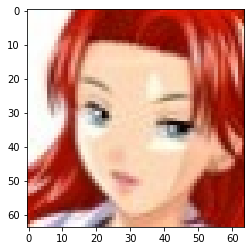

In [92]:
# 이미지 출력
plt.imshow(X_train[0])

In [93]:
# ImageSequence : 객체 생성
# images_path: 이미지 파일 경로
# 25 : 배치 사이즈
train_sequence = ImageSequence(images_path, 25)

In [94]:
# 이미지 파일을 X_train에 저장
for index, (X_train) in enumerate(train_sequence):
    # 반복 종료
    break

In [95]:
# 이미지 조회
X_train

array([[[[1.00000000e+00, 9.92156863e-01, 9.92156863e-01],
         [1.00000000e+00, 9.99632359e-01, 9.92156863e-01],
         [9.78308797e-01, 1.00000000e+00, 9.99387264e-01],
         ...,
         [7.99632370e-01, 1.23100489e-01, 1.87500007e-02],
         [7.44240224e-01, 1.38786763e-01, 5.28799035e-02],
         [6.47058845e-01, 9.01960805e-02, 1.17647061e-02]],

        [[1.00000000e+00, 9.88419116e-01, 9.88419116e-01],
         [1.00000000e+00, 9.99457121e-01, 9.91981685e-01],
         [9.85200286e-01, 1.00000000e+00, 9.99387264e-01],
         ...,
         [7.95836210e-01, 1.41438797e-01, 3.65042910e-02],
         [6.98102415e-01, 1.10812075e-01, 1.72545183e-02],
         [6.50796592e-01, 1.01409316e-01, 1.17647061e-02]],

        [[1.00000000e+00, 9.95465696e-01, 9.84620094e-01],
         [1.00000000e+00, 9.99787450e-01, 9.84912097e-01],
         [9.95537519e-01, 1.00000000e+00, 9.92156863e-01],
         ...,
         [9.60027933e-01, 3.65917981e-01, 2.56492227e-01],
         [

In [96]:
X_train.shape

(25, 64, 64, 3)

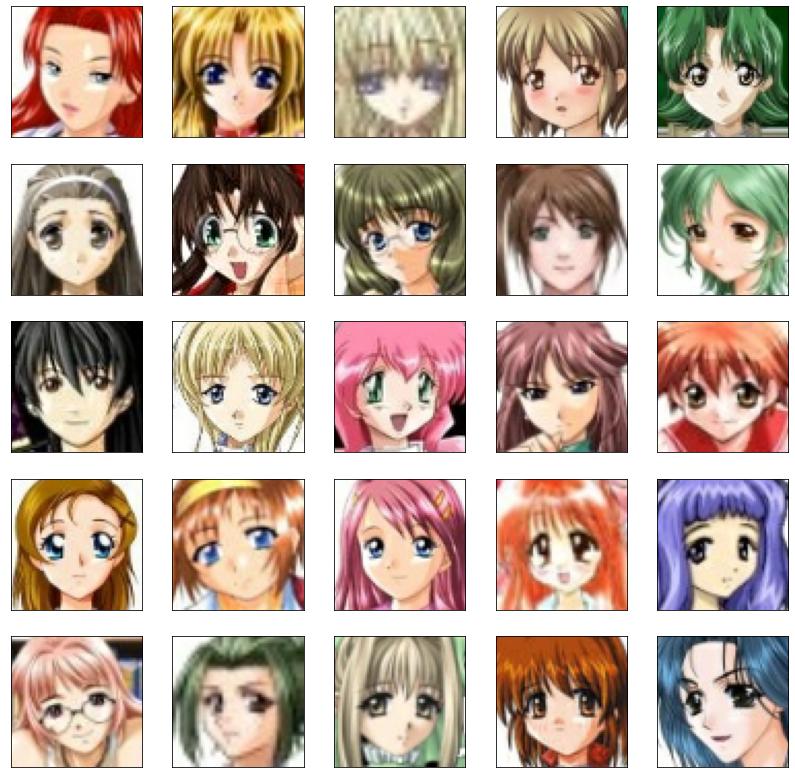

In [97]:
# 5줄의 5칸 가로 14 세로 14 그래프를 그림
fig, axes = plt.subplots(5,5, figsize = (14,14))

idx = 0
for row in range(5):
    for column in range(5):
        #X_train[idx] :를 row 줄 column 칸에 출력
        axes[row, column].imshow(X_train[idx])
         #x축 좌표가 출력되지 않도록 설정
        axes[row, column].get_xaxis().set_visible(False)
        #y축 좌표가 출력되지 않도록 설정
        axes[row, column].get_yaxis().set_visible(False)
        # idx 1증가
        idx+=1

In [98]:
latent_dim = 512

In [ ]:
# 분포에서 2개의 데이터를 선택
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a fashion mnist."""
    # inputs : 학습할 분포의 평균, 표준편차의 로그값이 각각 2개씩  저장된 리스트
    def call(self, inputs):
        # inputs에 저장된 평균을 z_mean에 대입
        # inputs에 저장된 표준편자의 로그값을 z_log_var에 저장 
        z_mean, z_log_var = inputs
        # 데이터의 줄의 수 리턴
        batch =  tf.shape(z_mean)[0]
        # 데이터의 칸의 수 리턴 (평균 표준 편차의 개수)
        dim = tf.shape(z_mean)[1]
        # 평균 0 표준편차 1인 난수  생성
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        # log(2) => 2.7    exp(2.7) => 2 : exp는 로그값을 원래 값으로 복원
        # 평균 + (0.5+표준편차로그)의 지수값 * 평균0 표준편차 1인 난수 => 분포에서 2개의 데이터를 랜덤하게 선택 
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# 64줄 64칸 컬러의 이미지를 입력 받음
encoder_inputs = Input(shape = (64,64,3))
# 32개 필터를 이용해서 CNN연산을 통해 이미지의 특성을 추출  
x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_inputs)
# BatchNormalization
x = BatchNormalization()(x)

# 64개 필터를 이용해서 CNN연산을 통해 이미지의 특성을 추출  
x = Conv2D(64, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
# BatchNormalization
x = BatchNormalization()(x)

# 128개 필터를 이용해서 CNN연산을 통해 이미지의 특성을 추출  
x = Conv2D(128, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
# BatchNormalization
x = BatchNormalization()(x)

# 256개 필터를 이용해서 CNN연산을 통해 이미지의 특성을 추출  
x = Conv2D(256, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
# BatchNormalization
x = BatchNormalization()(x)

# 512개 필터를 이용해서 CNN연산을 통해 이미지의 특성을 추출  
x = Conv2D(512, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
# BatchNormalization
x = BatchNormalization()(x)

# 1차원 배열로 변환
x = Flatten()(x)
# 1024번 선형 회귀
x = layers.Dense(1024, activation="relu")(x)
# BatchNormalization
x = BatchNormalization()(x)

# 평균을 생성
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
# 표준편차 로그값을 생성
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

In [ ]:
# z_mean, z_log_var를 입력받아서 2개의 sample 데이터를 리턴 받음
z = Sampling()([z_mean, z_log_var])

In [ ]:
#입력을 받아서 z_mean(평균), z_log_var(표준편차 로그값), z (분포에 포함되는 샘플) 을 리턴받는 모델 생성
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   2432        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   51264       ['batch_normalization[0][0]

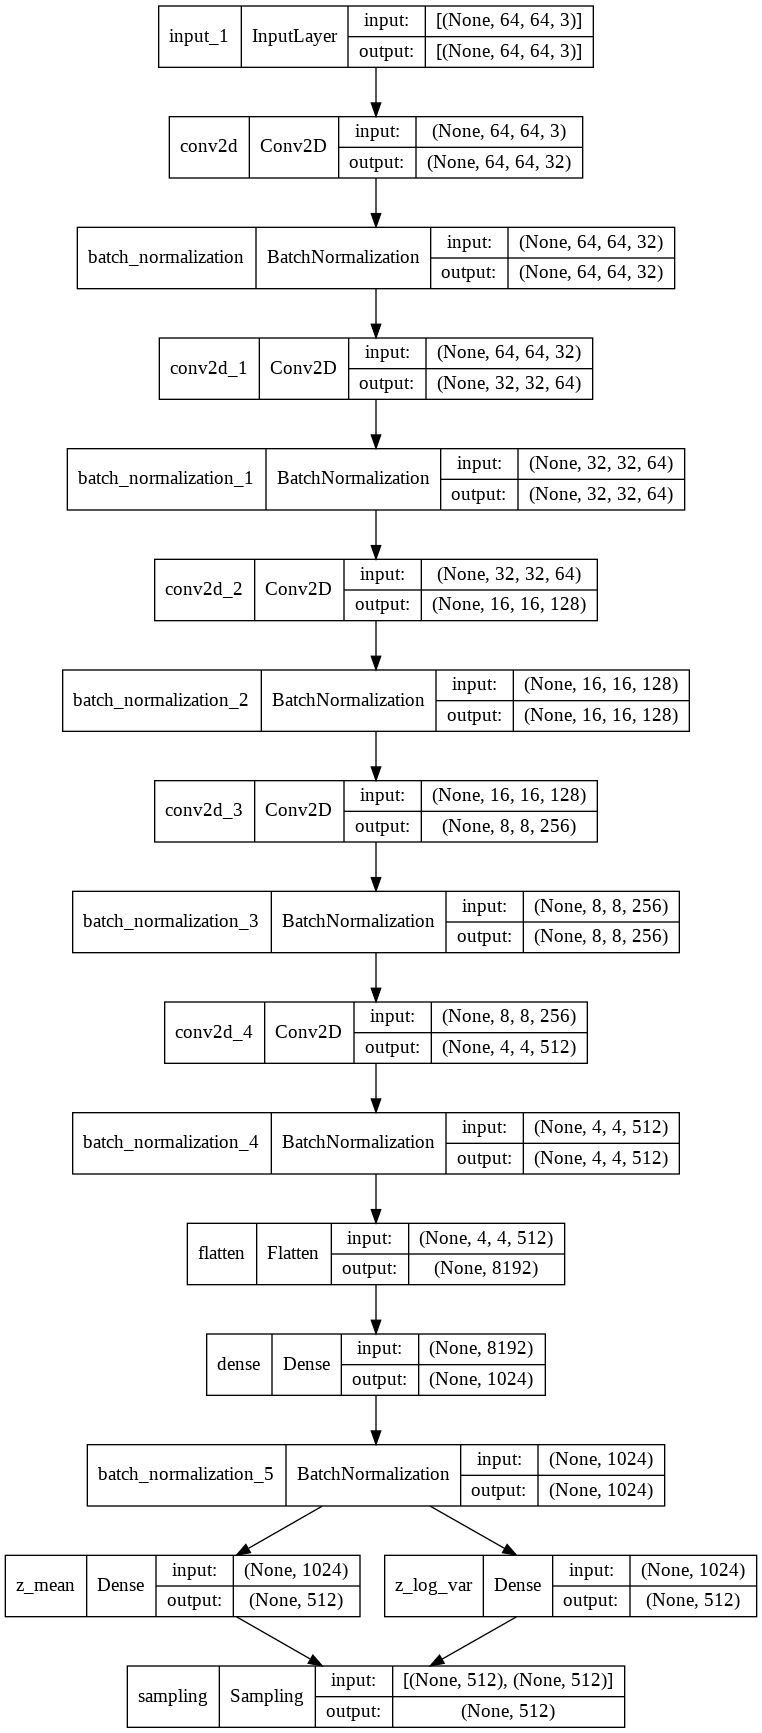

In [ ]:
from tensorflow.keras.utils  import plot_model
# encoder 출력
plot_model(encoder, show_shapes=True)

In [ ]:
# 512개의 샘플데이터를 입력으로 원래 이미지를 복원
# 512칸 입력 받음 (평균, 표준편차)
latent_inputs = Input(shape=(latent_dim,))

# 1024번 선형회귀
x = layers.Dense(1024, activation=selu)(latent_inputs)
# BatchNormalization
x = BatchNormalization()(x)

# 8192번 선형회귀
x = layers.Dense(8192, activation=selu)(x)
# BatchNormalization
x = BatchNormalization()(x)

# 4줄 4칸 512개 배열로 변환
x = Reshape((4,4,512))(x)

# 256개의 필터로 합성곱한 결과를 입력받아서 이미지로 복구
x = Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
# BatchNormalization
x = BatchNormalization()(x)

# 128개의 필터로 합성곱한 결과를 입력받아서 이미지로 복구
x = Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
# BatchNormalization
x = BatchNormalization()(x)

# 64개의 필터로 합성곱한 결과를 입력받아서 이미지로 복구
x = Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
# BatchNormalization
x = BatchNormalization()(x)

# 32개의 필터로 합성곱한 결과를 입력받아서 이미지로 복구
x = Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
# BatchNormalization
x = BatchNormalization()(x)

# 3개의 필터로 합성곱한 결과를 입력받아서 이미지로 복구
x = Conv2DTranspose(3, (5,5), activation = "sigmoid", strides = 1, padding = 'same')(x)
# BatchNormalization
decoder_outputs = BatchNormalization()(x)

In [ ]:
# 2칸의 데이터를 입력 받아서 28*28 출력하는 decoder 생성
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_6 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 8192)              8396800   
                                                                 
 batch_normalization_7 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0   

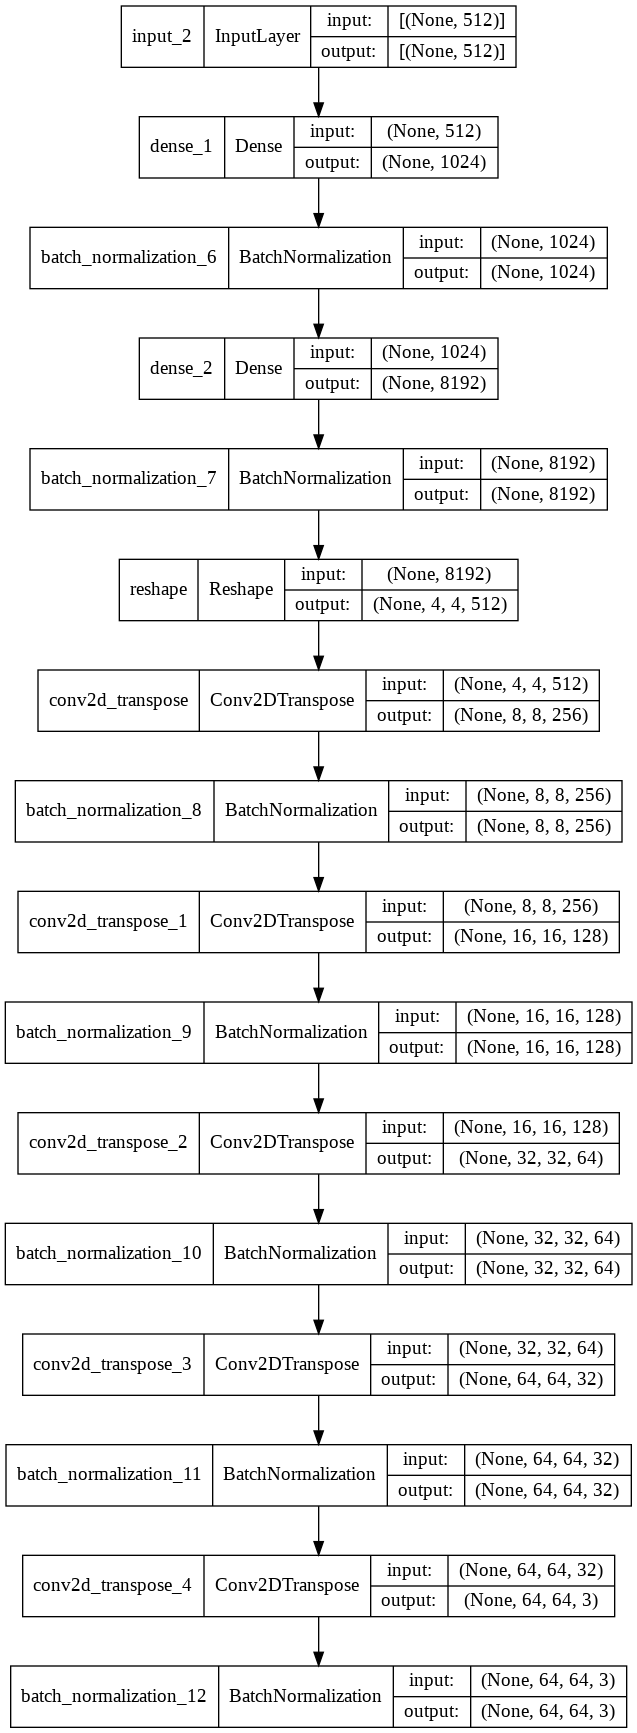

In [ ]:
from tensorflow.keras.utils  import plot_model
#decoder 출력
plot_model(decoder, show_shapes=True)

In [ ]:
# Variational Autoencoder 객체 선언
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        #객체 생성시 실행되는 함수
       
        super(VAE, self).__init__(**kwargs)
         #인코더와 디코더를 입력 받아서 속성에 저장  
        self.encoder = encoder
        self.decoder = decoder
    
    # 학습할때 실행되는 함수
    # 매개변수 data : 학습, 테스트 데이터
    def train_step(self, data):
        # tf.GradientTape() 기울기를 계산해서 weight를 수정할 객체 리턴
        with tf.GradientTape() as tape:
            #입력을 받아서 z_mean(평균), z_log_var(표준편차 로그값), z (분포에 포함되는 샘플) 을 리턴받는 모델 생성
            z_mean, z_log_var, z = self.encoder(data)
            # 2칸의 데이터(2개의 샘플데이터)를 입력 받아서 64*64 출력 (생성 이미지)
            reconstruction = self.decoder(z)
            # 원본이미지와 생성 이미지의 차를 계산  
            reconstruction_loss = mse(data, reconstruction)
            # 오차에 데이터 수를 곱해서 값을 키워줌
            reconstruction_loss *= (64 * 64)
            # 실제 데이터의 분포 p(x) 와 encoder가 추정한 분포 q(x) 사이의 차를 계산
            kl_loss = -0.5*(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var) )
            # 실제 데이터의 분포 p(x) 와 encoder가 추정한 분포 q(x) 사이의 오차의 평균
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=-1))
            # reconstruction_loss (원본과 생성 이미지의 오차) + kl_loss (실제 데이터의 분포 p(x) 와 encoder가 추정한 분포 q(x) 사이의 오차)
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        # 기울기 계산    
        grads = tape.gradient(total_loss, self.trainable_weights)
        # weight 업데이트
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # 학습할때 마다 화면에 출력하는 값
        return {
             # reconstruction_loss (원본과 생성 이미지의 오차) + kl_loss (실제 데이터의 분포 p(x) 와 encoder가 추정한 분포 q(x) 사이의 오차) 리턴
            "total_loss": total_loss,
            # 원본이미지와 생성 이미지의 오차 리턴
            "reconstruction_loss": reconstruction_loss,
             # 실제 데이터의 분포 p(x) 와 encoder가 추정한 분포 q(x) 사이의 오차 리턴
            "kl_loss": kl_loss
        }

In [ ]:
# ImageSequence : 객체 생성
# images_path: 이미지 파일 경로
# 200 : 배치 사이즈
train_sequence = ImageSequence(images_path, 200)

In [ ]:
# Variational Autoencoder 객체 생성
vae = VAE(encoder, decoder)

In [ ]:
# Variational Autoencoder 옵티마이저 설정
vae.compile(optimizer=Adam(learning_rate=0.0001, beta_1 = 0.5))

In [ ]:
# Variational Autoencoder학습
vae.fit(train_sequence , epochs=2000, shuffle=True)

Epoch 1/1000
40/40 [==============================] - 3s 67ms/step - total_loss: 123.8397 - reconstruction_loss: 98.1516 - kl_loss: 25.6881
Epoch 2/1000
40/40 [==============================] - 3s 69ms/step - total_loss: 114.2835 - reconstruction_loss: 87.4121 - kl_loss: 26.8713
Epoch 3/1000
40/40 [==============================] - 3s 69ms/step - total_loss: 102.7532 - reconstruction_loss: 76.5975 - kl_loss: 26.1557
Epoch 4/1000
40/40 [==============================] - 3s 69ms/step - total_loss: 99.5087 - reconstruction_loss: 72.8746 - kl_loss: 26.6341
Epoch 5/1000
40/40 [==============================] - 3s 69ms/step - total_loss: 96.7367 - reconstruction_loss: 70.1148 - kl_loss: 26.6219
Epoch 6/1000
40/40 [==============================] - 3s 68ms/step - total_loss: 93.6862 - reconstruction_loss: 67.3307 - kl_loss: 26.3555
Epoch 7/1000
40/40 [==============================] - 3s 69ms/step - total_loss: 92.4143 - reconstruction_loss: 66.2722 - kl_loss: 26.1421
Epoch 8/1000
40/40 [====

In [ ]:
# 모델 저장
#vae.save_weights("/content/drive/MyDrive/cloud_ai/18.gan/workspace/vae_ani_cnn")

In [ ]:
# 모델 객체 생성
model = VAE(encoder, decoder)

In [ ]:
# 저장한 weight 로드
model.load_weights("/content/drive/MyDrive/cloud_ai/18.gan/workspace/vae_ani_cnn")

In [ ]:
# ImageSequence : 객체 생성
# images_path: 이미지 파일 경로
# 25 : 배치 사이즈
train_sequence = ImageSequence(images_path, 25)

In [ ]:
# 이미지 파일을 X_train 에 저장
for index, (X_train) in enumerate(train_sequence):
    # 반복 종료
    break

In [ ]:
# X_test에서 z_mean(평균), z_log_var (표준편차의 로그값), z(분포에서 선택한 샘플 512개씩)
z_mean, z_log_var, z = model.encoder(X_train[0:25])

In [ ]:
# 데이터 분포 평균 조회
z_mean

<tf.Tensor: shape=(25, 512), dtype=float32, numpy=
array([[ 0.00027794,  0.00481303,  0.0148493 , ..., -0.00351263,
        -0.00091704, -0.02300202],
       [-0.00377678, -0.01267092, -0.00864449, ..., -0.01032817,
         0.00758437,  0.00374355],
       [-0.00764951, -0.01151578, -0.00747431, ..., -0.01654783,
        -0.00505694,  0.0028119 ],
       ...,
       [-0.01407335,  0.00376464, -0.0025997 , ..., -0.01026049,
        -0.00199265, -0.02521685],
       [-0.01564272,  0.01532403,  0.00121964, ..., -0.00776332,
        -0.01832286, -0.00859083],
       [ 0.00714491, -0.00511784,  0.00829753, ..., -0.01041434,
         0.00933269, -0.00090508]], dtype=float32)>

In [ ]:
#데이터 분포 표준편차의 로그값 조회
z_log_var

<tf.Tensor: shape=(25, 512), dtype=float32, numpy=
array([[-0.02152028,  0.00484317,  0.00122825, ..., -0.02276961,
        -0.0022122 , -0.00245227],
       [-0.0120158 ,  0.02752238, -0.00467144, ..., -0.01358506,
        -0.0012369 ,  0.00543693],
       [-0.00530371, -0.00184526, -0.00841987, ..., -0.00491172,
         0.00148281, -0.00482962],
       ...,
       [ 0.01122729,  0.00676585, -0.00962884, ...,  0.01710862,
        -0.00013041,  0.00981876],
       [-0.00653287,  0.01993256,  0.00990755, ..., -0.02071917,
        -0.00676069,  0.00297484],
       [ 0.00861589,  0.01576239,  0.01846465, ..., -0.02122971,
         0.00364332, -0.00457013]], dtype=float32)>

In [ ]:
# 분포에서 선택한 샘플값
z

<tf.Tensor: shape=(25, 512), dtype=float32, numpy=
array([[ 0.48845193,  1.4252226 , -1.115496  , ..., -0.5037325 ,
         0.23831205,  0.50470436],
       [ 0.14696966, -1.432184  ,  1.5338455 , ...,  0.9084007 ,
        -0.64175063,  0.42001972],
       [-0.20446284, -0.84161186,  0.0583409 , ..., -0.4625438 ,
         0.42753795,  0.56303066],
       ...,
       [ 0.72566354,  0.48691887, -0.90275884, ..., -0.8950524 ,
         1.0206941 ,  0.00558547],
       [-2.13824   , -0.525017  , -0.48033488, ..., -0.0223574 ,
        -0.9314561 , -0.93288875],
       [-1.7141315 , -0.388992  ,  1.0062727 , ...,  0.97566384,
         0.48401794,  0.90462554]], dtype=float32)>

In [ ]:
# z를 이용하여 이미지 생성
generate_data = model.decoder(z)

In [ ]:
# 생성된 이미지의 모양 조회
generate_data.shape

TensorShape([25, 64, 64, 3])

In [ ]:
# 생성된 데이터
generate_data

<tf.Tensor: shape=(25, 64, 64, 3), dtype=float32, numpy=
array([[[[0.9799619 , 0.97183824, 0.94041276],
         [0.99097943, 0.98390377, 0.9638259 ],
         [0.9944165 , 0.9899142 , 0.97167337],
         ...,
         [0.9894087 , 0.9860418 , 0.97467464],
         [0.9905708 , 0.9853315 , 0.9747796 ],
         [0.98642   , 0.98122007, 0.9694985 ]],

        [[0.99113566, 0.98561007, 0.9693649 ],
         [0.9885211 , 0.98371464, 0.96613216],
         [0.9932125 , 0.9884554 , 0.97340834],
         ...,
         [0.98131216, 0.9764194 , 0.96275514],
         [0.9888386 , 0.9832362 , 0.9720156 ],
         [0.99246526, 0.9851034 , 0.97583187]],

        [[0.99370027, 0.9876562 , 0.97474396],
         [0.9790755 , 0.9753556 , 0.9532588 ],
         [0.98548675, 0.9828875 , 0.96304935],
         ...,
         [0.979648  , 0.9783061 , 0.96086395],
         [0.9690192 , 0.96876335, 0.94506973],
         [0.98353827, 0.97980803, 0.96662456]],

        ...,

        [[0.715038  , 0.6444062 , 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

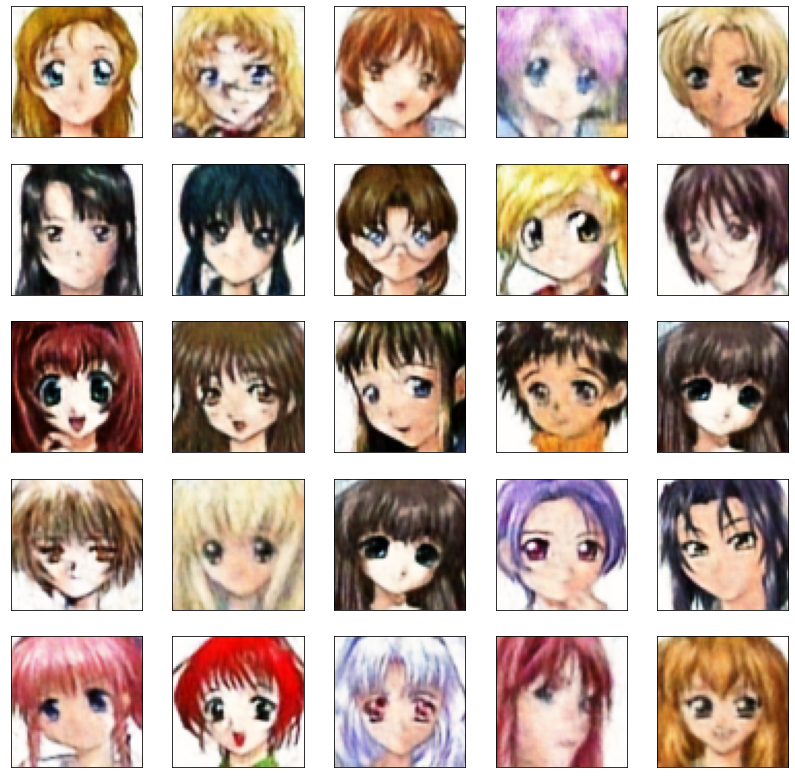

In [ ]:
# 5줄의 5칸 가로 14 세로 14 그래프를 그림
fig, axes = plt.subplots(5,5, figsize = (14,14))

idx = 0
for row in range(5):
    for column in range(5):
        #generate_data[idx] : 생성이미지 generate_date[idx]를 row 줄 column 칸에 출력
        axes[row, column].imshow(generate_data[idx].numpy())
         #x축 좌표가 출력되지 않도록 설정
        axes[row, column].get_xaxis().set_visible(False)
        #y축 좌표가 출력되지 않도록 설정
        axes[row, column].get_yaxis().set_visible(False)
        # idx 1증가
        idx+=1
